# play with pyMC in order to extract nonlinear internal wave signatures on pictures

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, Uniform, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


---
## Start with [GLM linear example](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

#%config InlineBackend.figure_format = 'retina'
#az.style.use("arviz-darkgrid")

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

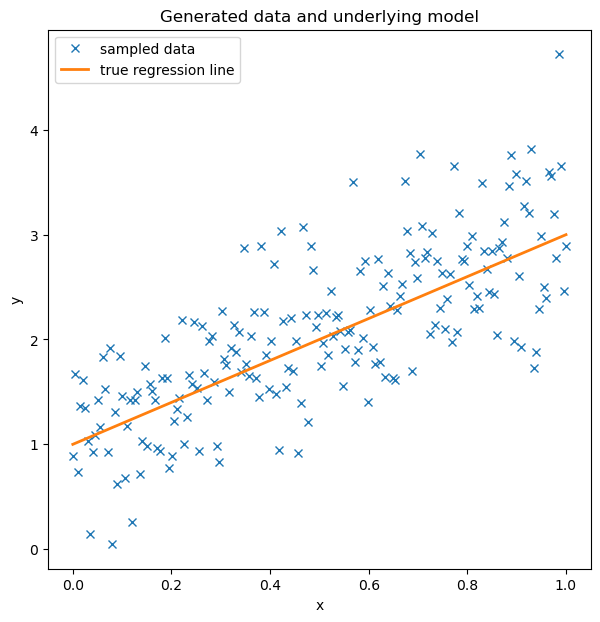

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


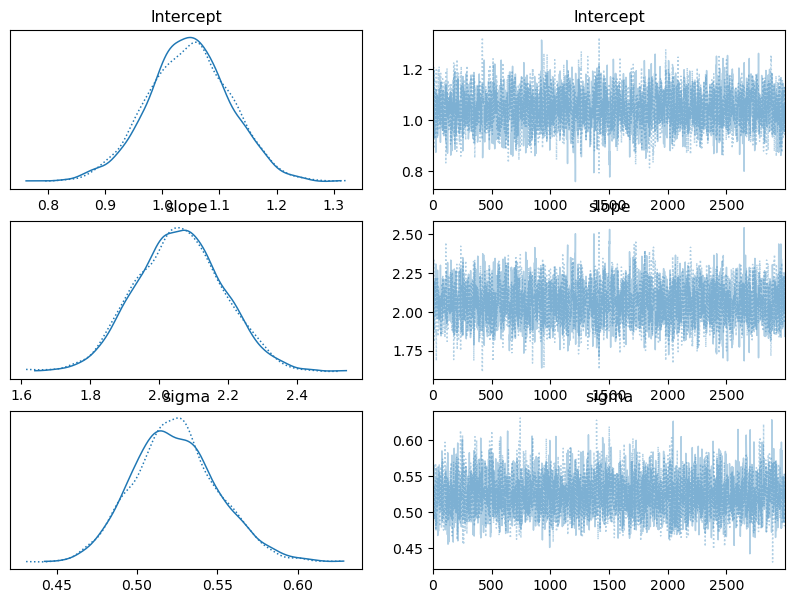

In [7]:
az.plot_trace(idata, figsize=(10, 7));

---
## gaussian ridge extraction on a 2D picture

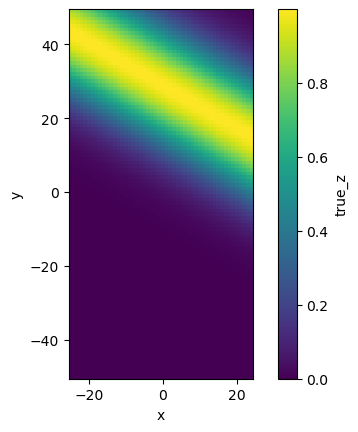

In [8]:
size_x, size_y = 50, 100
true_delta = size_x/2
true_width = 10
true_theta = np.pi/3

true_amplitude = 1

ds = xr.Dataset(None, coords=dict(x=np.arange(-size_x/2, size_x/2), y=np.arange(-size_y/2, size_y/2)))

ridge = lambda x, y, width, theta, delta, amplitude : \
        amplitude * np.exp(-( np.cos(theta)*x + np.sin(theta)*y - delta )**2/width**2*0.5)

ds["true_z"] = ridge(ds.x, ds.y, true_width, true_theta, true_delta, true_amplitude)

fig, ax = plt.subplots(1,1)
ds["true_z"].plot(x="x")
ax.set_aspect("equal")

In [9]:
dss = ds.stack(point=["x", "y"])
size = dss.point.size

In [10]:
# add noise
y = dss.true_z + rng.normal(scale=0.5, size=size)

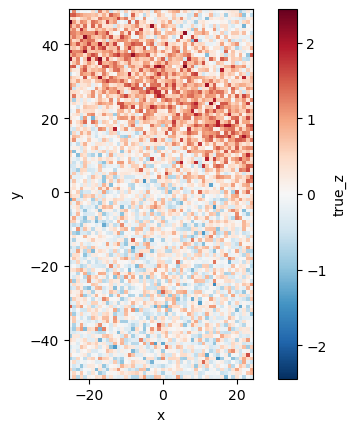

In [11]:
fig, ax = plt.subplots(1,1)
y.unstack().plot(x="x")
ax.set_aspect("equal")

In [12]:
from pymc import Uniform

with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    
    # Define priors
    #sigma = HalfCauchy("sigma", beta=10)
    sigma = Uniform("sigma", 0, 10)
    #x_origin = Normal("X_origin", 0, sigma=size_x/2) 
    delta = Uniform("Delta", 0, size_x)   # be careful here with actual projections ... will need to temporally recenter projections
    #width = HalfCauchy("Width", beta=10*true_width)
    width = Uniform("Width", 1, 10*true_width)
    theta = Uniform("Theta", 0, np.pi)
    #amplitude = HalfCauchy("Amplitude", beta=10*true_amplitude)
    amplitude = Uniform("Amplitude", true_amplitude/10, 10*true_amplitude)
    
    # Define likelihood
    mu = ridge(dss.x.values, dss.y.values, width, theta, delta, amplitude)
    likelihood = Normal("y", mu=mu, sigma=sigma, observed=y.values)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Delta, Width, Theta, Amplitude]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


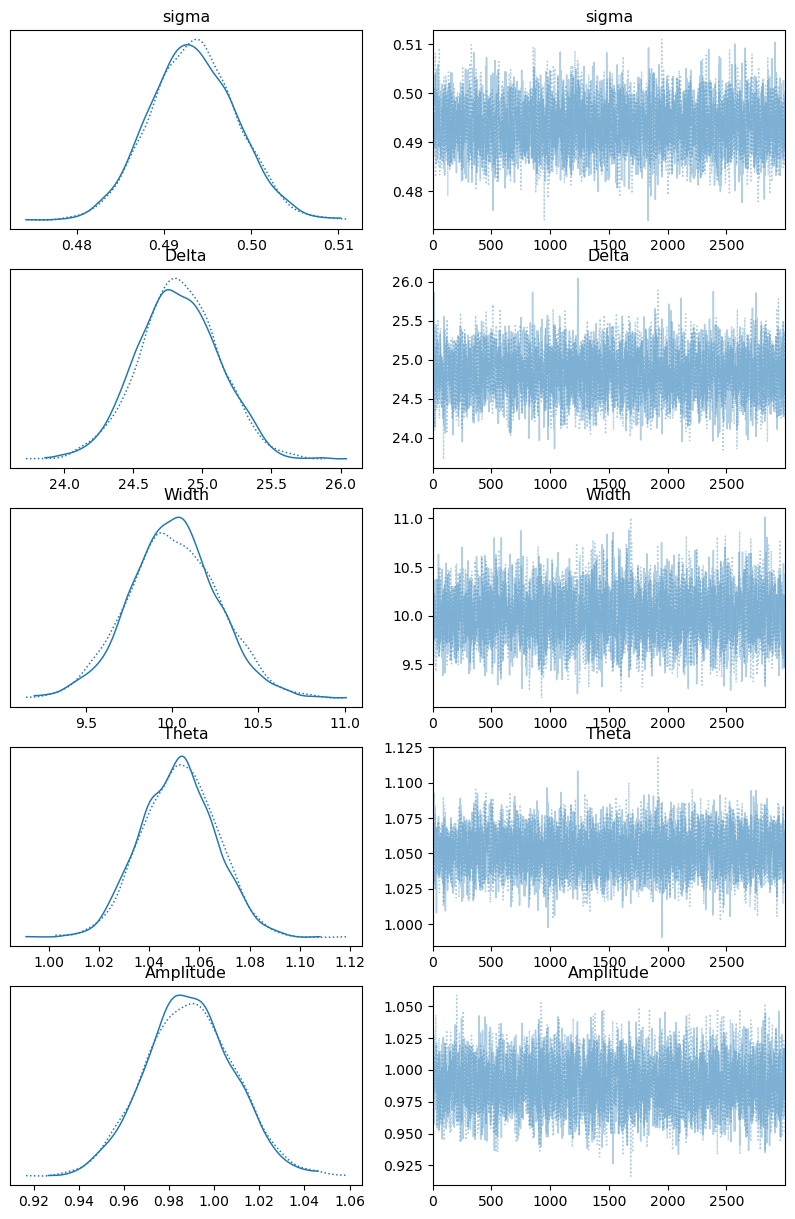

In [18]:
az.plot_trace(idata, figsize=(10, 15), );

array([[<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Delta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Width'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Theta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='sigma', ylabel='Amplitude'>,
        <Axes: xlabel='Delta'>, <Axes: xlabel='Width'>,
        <Axes: xlabel='Theta'>, <Axes: xlabel='Amplitude'>]], dtype=object)

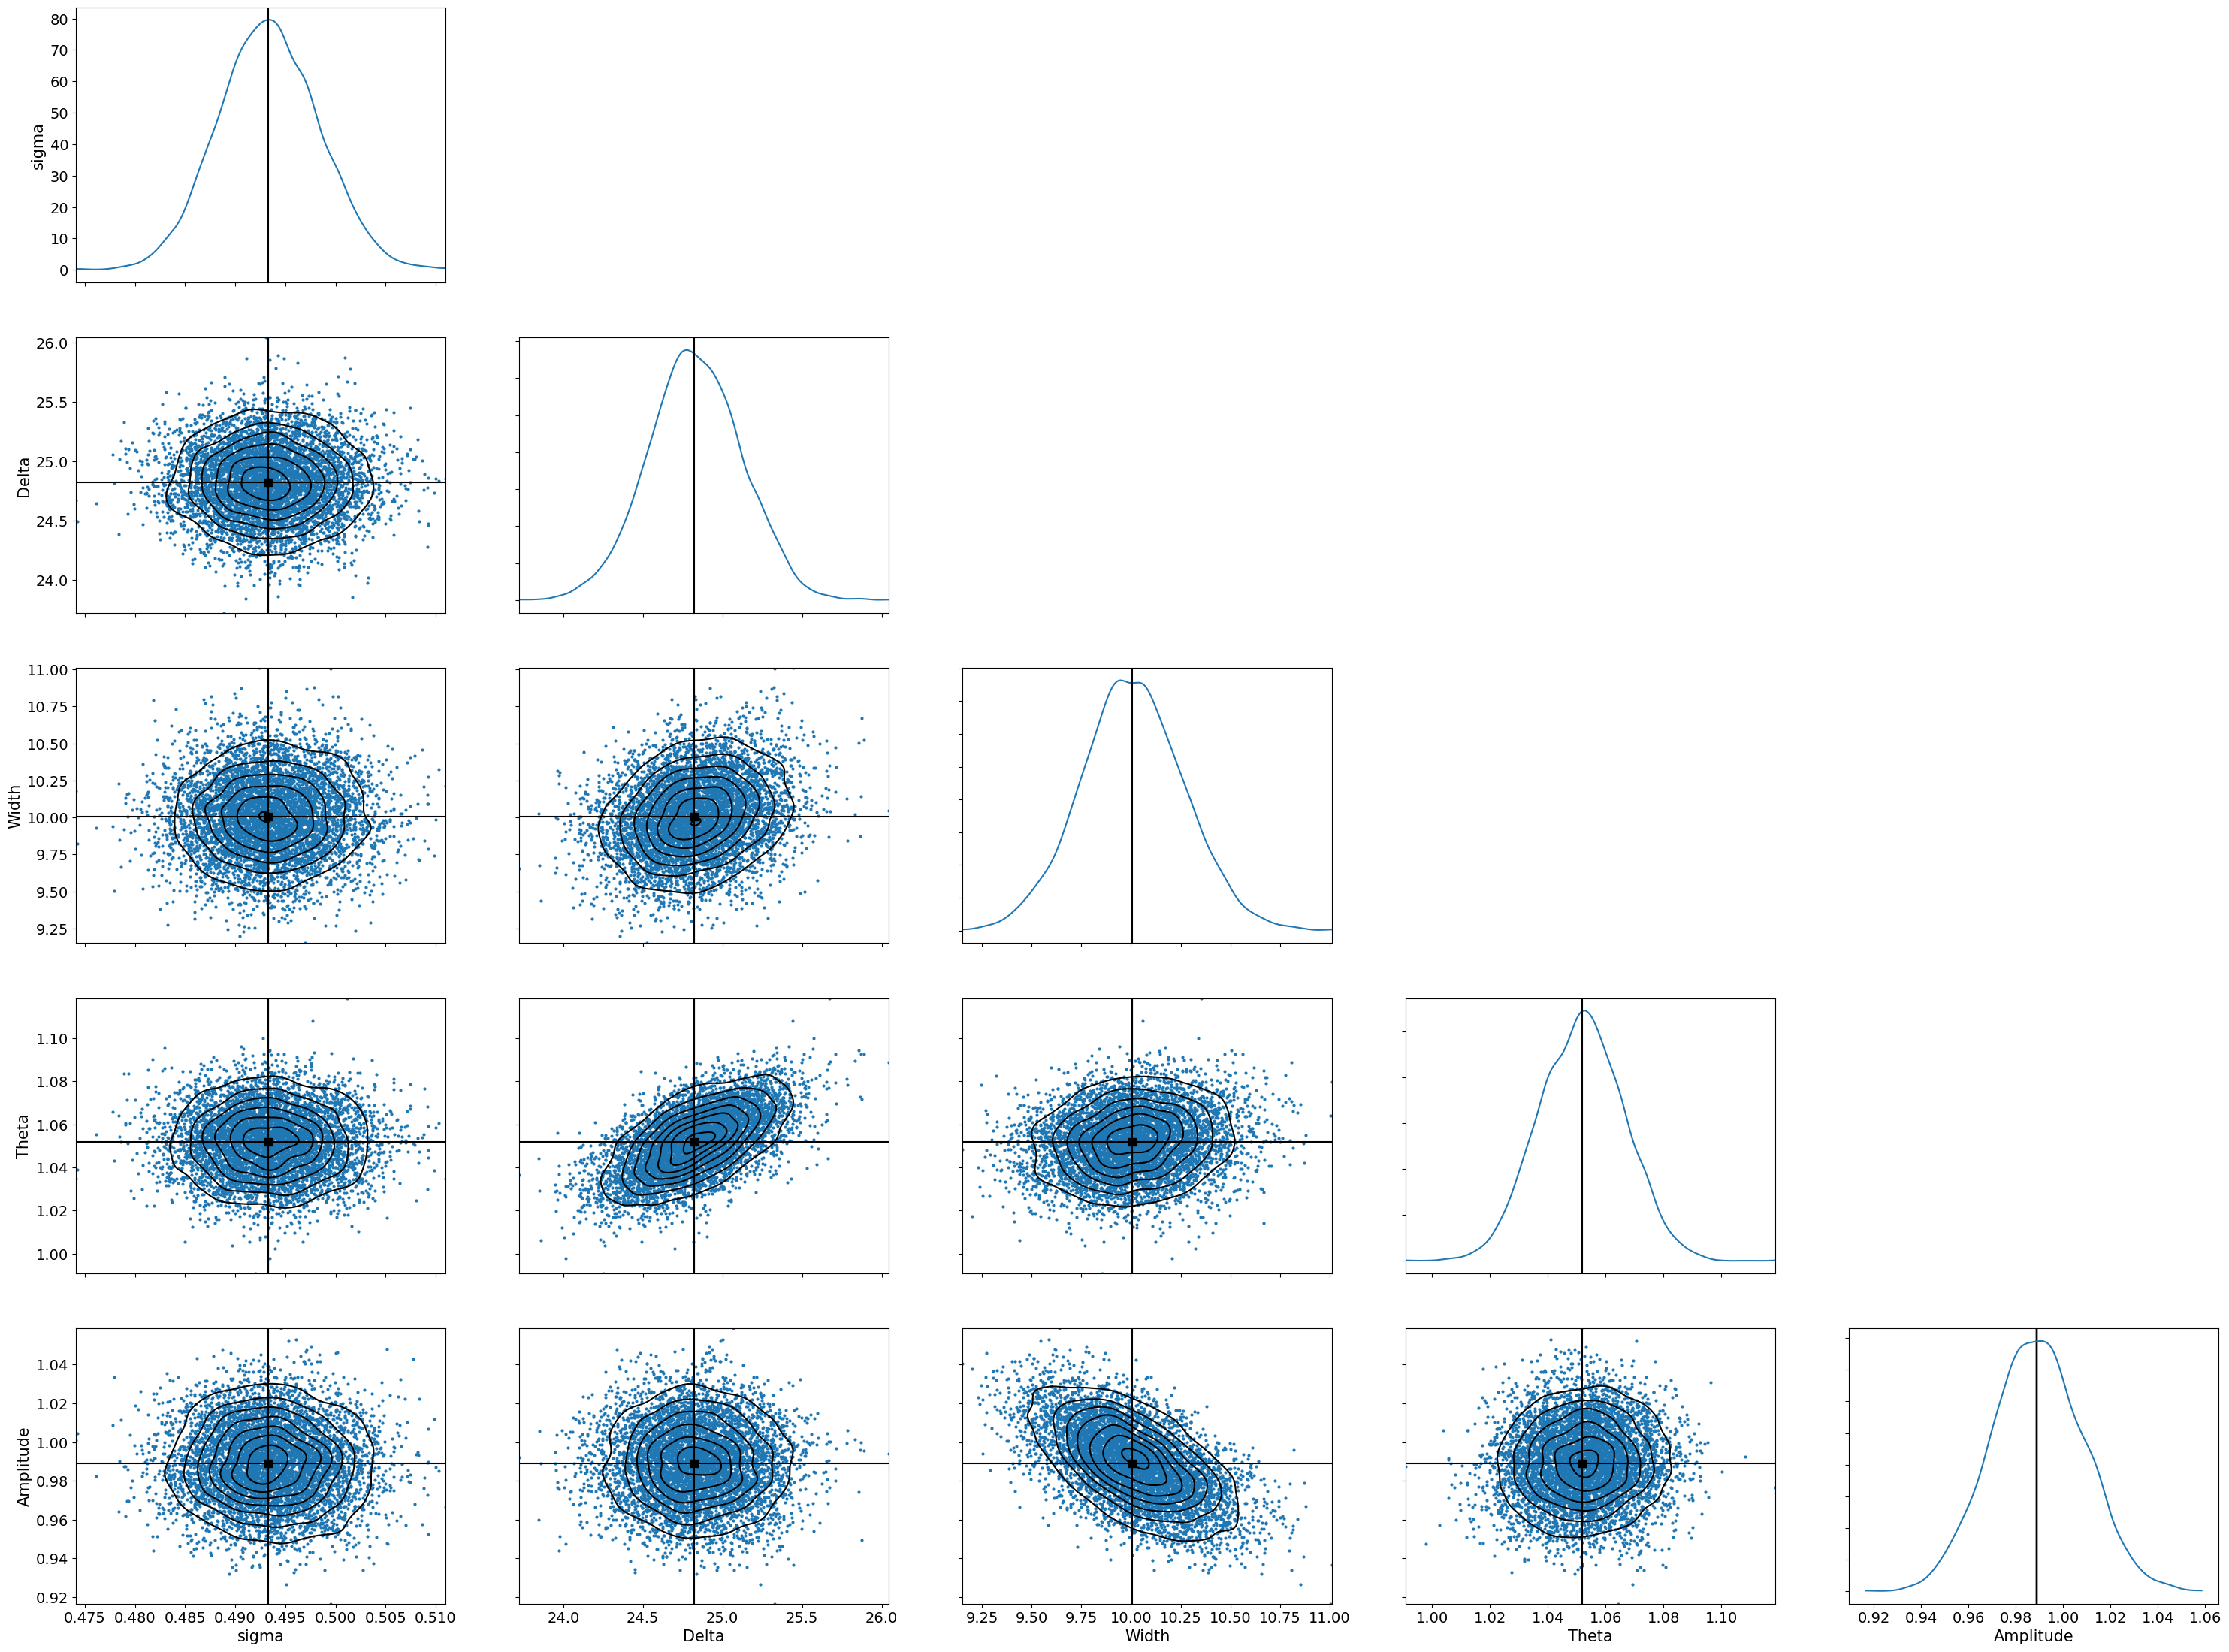

In [19]:
az.plot_pair(idata,
    kind=["scatter", "kde"],
    #kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
)

In [15]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.49,0.00,0.48,0.50,0.0,0.0,5975.06,4502.46,1.0
Delta,24.83,0.29,24.31,25.41,0.0,0.0,5212.73,4476.85,1.0
Width,10.01,0.26,9.52,10.50,0.0,0.0,4680.05,4542.39,1.0
Theta,1.05,0.01,1.02,1.08,0.0,0.0,5599.60,4990.27,1.0
Amplitude,0.99,0.02,0.95,1.03,0.0,0.0,4851.91,4498.54,1.0
